<a href="https://colab.research.google.com/github/souzamichel/ml_trading_test_code/blob/main/ml_trading_por_reforco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episódio 50/300 - Recompensa acumulada: 47.26
Episódio 100/300 - Recompensa acumulada: 37.72
Episódio 150/300 - Recompensa acumulada: 55.45
Episódio 200/300 - Recompensa acumulada: 86.70
Episódio 250/300 - Recompensa acumulada: 71.53
Episódio 300/300 - Recompensa acumulada: 83.87


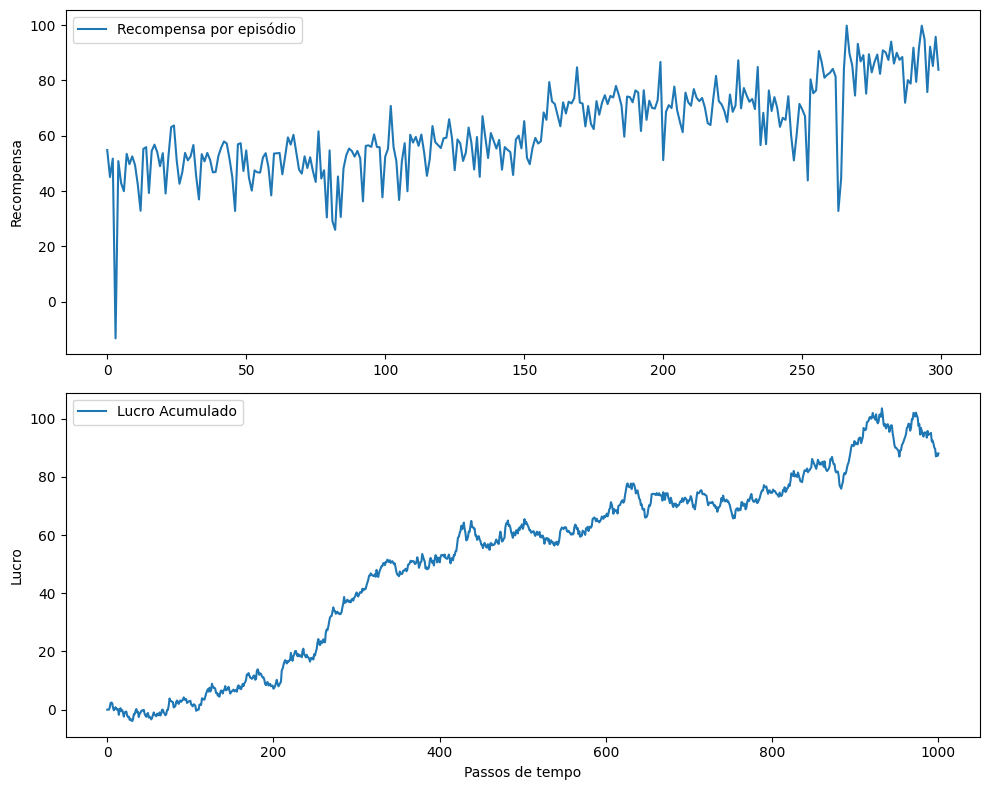

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

class TradingEnv:
    """
    Ambiente de trading com três ações: 0=Manter, 1=Comprar, 2=Vender.
    Estado = (índice do bin de retorno, posição atual).
    """
    def __init__(self, prices, n_return_bins=10):
        self.prices = prices
        self.n_bins = n_return_bins
        # calcula retornos diários e seus bins
        self.returns = np.diff(self.prices) / self.prices[:-1]
        self.bins = np.linspace(self.returns.min(), self.returns.max(), self.n_bins + 1)
        self.reset()

    def reset(self):
        self.t = 0
        self.position = 0    # -1=vendido, 0=neutro, +1=comprado
        self.cash = 0.0
        self.inventory = 0.0
        return self._get_state()

    def _get_state(self):
        if self.t >= len(self.returns):  # último passo
            ret = self.returns[-1]
        else:
            ret = self.returns[self.t]
        bin_idx = np.digitize(ret, self.bins) - 1
        bin_idx = np.clip(bin_idx, 0, self.n_bins - 1)
        pos_idx = self.position + 1  # transforma -1,0,1 em 0,1,2
        return (bin_idx, pos_idx)

    def step(self, action):
        """
        Executa a ação e retorna (next_state, reward, done).
        Reward = lucro/perda instantâneo pela variação de preço * posição anterior.
        """
        price_prev = self.prices[self.t]
        self.t += 1
        price_now = self.prices[self.t]
        # calcula recompensa com posição anterior
        reward = self.position * (price_now - price_prev)
        # atualiza posição
        if action == 1:
            self.position = 1
        elif action == 2:
            self.position = -1
        else:
            self.position = self.position  # mantém
        done = (self.t == len(self.prices) - 1)
        next_state = self._get_state()
        return next_state, reward, done

class QLearningAgent:
    """
    Agente de Q-Learning tabular.
    """
    def __init__(self, n_return_bins, n_position_states, n_actions,
                 alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.n_states = (n_return_bins, n_position_states)
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        # Q-table inicializada com zeros
        self.Q = np.zeros((n_return_bins, n_position_states, n_actions))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        r_idx, p_idx = state
        return np.argmax(self.Q[r_idx, p_idx, :])

    def update(self, state, action, reward, next_state):
        r, p = state
        nr, np_ = next_state
        q_predict = self.Q[r, p, action]
        q_target = reward + self.gamma * np.max(self.Q[nr, np_, :])
        self.Q[r, p, action] += self.alpha * (q_target - q_predict)
        # decai epsilon
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

def generate_price_series(n_steps=1000, S0=100, mu=0.0002, sigma=0.01, seed=42):
    """
    Gera série de preços por Geometric Brownian Motion.
    """
    np.random.seed(seed)
    dt = 1.0
    prices = [S0]
    for _ in range(n_steps):
        shock = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        prices.append(prices[-1] * np.exp(shock))
    return np.array(prices)

def train_agent(env, agent, n_episodes=200):
    history = {'episode_rewards': []}
    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            agent.update(state, action, reward, next_state)
            state = next_state
            total_reward += reward
        history['episode_rewards'].append(total_reward)
        if (ep + 1) % 50 == 0:
            print(f'Episódio {ep+1}/{n_episodes} - Recompensa acumulada: {total_reward:.2f}')
    return history

def evaluate_agent(env, agent):
    state = env.reset()
    done = False
    portfolio = [0.0]  # valor acumulado
    cum_reward = 0.0
    while not done:
        action = np.argmax(agent.Q[state[0], state[1], :])
        state, reward, done = env.step(action)
        cum_reward += reward
        portfolio.append(cum_reward)
    return portfolio

def main():
    # 1) Gera dados sintéticos
    prices = generate_price_series(n_steps=1000)
    env = TradingEnv(prices, n_return_bins=20)

    # 2) Cria o agente Q-Learning
    agent = QLearningAgent(
        n_return_bins=env.n_bins,
        n_position_states=3,
        n_actions=3,
        alpha=0.1, gamma=0.99,
        epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01
    )

    # 3) Treina o agente
    history = train_agent(env, agent, n_episodes=300)

    # 4) Avalia desempenho
    portfolio = evaluate_agent(env, agent)

    # 5) Plota resultados
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)
    axes[0].plot(history['episode_rewards'], label='Recompensa por episódio')
    axes[0].set_ylabel('Recompensa')
    axes[0].legend()
    axes[1].plot(portfolio, label='Lucro Acumulado')
    axes[1].set_ylabel('Lucro')
    axes[1].set_xlabel('Passos de tempo')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
